# Fleet utilization rate
To show the utilization of the bike sharing service, we calculate the utilization rate. It denotes the proportion of bikes used per hour out of the total number of available bikes in the provider's fleet.
$$ \text{utilization rate} = {\text{used bikes}\over \text{amount of available bikes}} $$
### Load data
In *data_preparation.ipynb* we have already created a table in which the trips have been decomposed according to the times of day (hours). This allows us to easily calculate the utilization rate based on the number of rows in a given hour.

In [2]:
import pandas as pd
import numpy as np
df_splitted_trips = pd.read_csv('./data/prepared/rides_data_split_into_hours.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_splitted_trips['start_time'] = pd.to_datetime(df_splitted_trips['start_time'], format='%Y-%m-%d %X')
df_splitted_trips['end_time'] = pd.to_datetime(df_splitted_trips['end_time'], format='%Y-%m-%d %X')
df_splitted_trips['Date'] = df_splitted_trips['start_time'].dt.date
df_splitted_trips['Time of day (hour)'] = df_splitted_trips['start_time'].dt.hour
amountOfBikes = len(df_splitted_trips['bike_id'].unique())
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_splitted_trips = df_splitted_trips.copy()
df_splitted_trips['Weekday'] = df_splitted_trips['start_time'].dt.day_name()

### Calculate utilization rate per hour

To calculate the usage rate, we need to calculate the number of bicycles used for each row. Subsequently, this is set in relation to the total number of bicycles.

In [3]:
import seaborn as sns
df_utilization_rate_per_hour = df_splitted_trips.copy()
df_utilization_rate_per_hour = df_utilization_rate_per_hour.groupby(['Date', 'Weekday', 'Time of day (hour)']).nunique()
df_utilization_rate_per_hour['Utilization rate in %'] = df_utilization_rate_per_hour['bike_id']/amountOfBikes*100
df_utilization_rate_per_hour.head()

start_time  end_time  \
Date       Weekday  Time of day (hour)                         
2015-01-01 Thursday 0                            4         4   
                    1                            4         4   
                    2                            1         1   
                    4                            1         1   
                    8                            4         4   

                                        start_station_id  end_station_id  \
Date       Weekday  Time of day (hour)                                     
2015-01-01 Thursday 0                                  3               3   
                    1                                  4               4   
                    2                                  1               1   
                    4                                  1               1   
                    8                                  4               4   

                                        start_station_name  end_station_name  \
Date       Weekday  Time of day (hour)                                         
2015-01-01 Thursday 0                                    3                 3   
                    1                                    4                 4   
                    2                                    1                 1   
                    4                                    1                 1   
                    8                                    4                 4   

                                        bike_id  user_type  trip_length  \
Date       Weekday  Time of day (hour)                                    
2015-01-01 Thursday 0                         4          1            4   
                    1                         4          2            4   
                    2                         1          1            1   
                    4                         1          1            1   
                    8                         3          1            4   

                                        start_station_latitude  \
Date       Weekday  Time of day (hour)                           
2015-01-01 Thursday 0                                        3   
                    1                                        4   
                    2                                        1   
                    4                                        1   
                    8                                        4   

                                        start_station_longitude  \
Date       Weekday  Time of day (hour)                            
2015-01-01 Thursday 0                                         3   
                    1                                         4   
                    2                                         1   
                    4                                         1   
                    8                                         4   

                                        end_station_latitude  \
Date       Weekday  Time of day (hour)                         
2015-01-01 Thursday 0                                      3   
                    1                                      4   
                    2                                      1   
                    4                                      1   
                    8                                      4   

                                        end_station_longitude  \
Date       Weekday  Time of day (hour)                          
2015-01-01 Thursday 0                                       3   
                    1                                       4   
                    2                                       1   
                    4                                       1   
                    8                                       4   

                                        start_station_municipality  \
Date       Weekday  Time of day (hour)                         

### Insert utilization rate of 0 for hours without ride

If no trip has taken place in an hour, an Utilization Rate of 0% must be inserted in this line.

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'

df_utilization_rate_per_hour_reset = df_utilization_rate_per_hour.reset_index(level=1)

indexes = df_utilization_rate_per_hour_reset.index.to_list()
hours = set(range(24))

dict_rides_with_hours = {}
for index in indexes:
    if index[0] not in dict_rides_with_hours.keys():
        dict_rides_with_hours[index[0]] = set([index[1]])
    else:
        dict_rides_with_hours[index[0]].add(index[1])
dict_rides_without_hours = {}
for key, value in dict_rides_with_hours.items():
    missing_hours = hours - value
    if key not in dict_rides_without_hours.keys():
        dict_rides_without_hours[key] = missing_hours
df_utilization_rate_per_hour_reset2 = df_utilization_rate_per_hour_reset.reset_index()
df_utilization_rate_per_hour_reduced = df_utilization_rate_per_hour_reset2[['Date','Time of day (hour)','Utilization rate in %']]
for key, value in dict_rides_without_hours.items():
    for hour in value:
        df_utilization_rate_per_hour_reduced.loc[len(df_utilization_rate_per_hour_reduced.index)] = [key, hour, 0]
    
df_utilization_rate_per_hour_reduced.sort_values(by=['Date', 'Time of day (hour)'], inplace=True)        
df_utilization_rate_per_hour_reduced=df_utilization_rate_per_hour_reduced.reset_index(drop=True)
df_utilization_rate_per_hour_reduced.head()

,Date,Time of day (hour),Utilization rate in %
0,2015-01-01,0,0.268817
1,2015-01-01,1,0.268817
2,2015-01-01,2,0.067204
3,2015-01-01,3,0.000000
4,2015-01-01,4,0.067204


### Boxplot: Distribution of hourly utilization rate

To show the distribution of the utilization rate, we use a boxplot.

<AxesSubplot: xlabel='Time of day (hour)', ylabel='Utilization rate in %'>

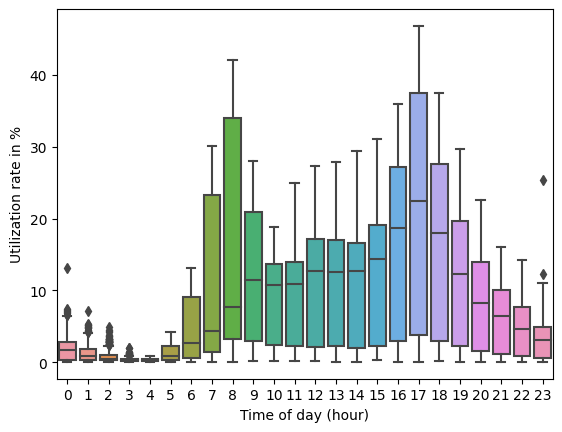

In [5]:
df_utilization_rate_per_hour_reset_index = df_utilization_rate_per_hour.reset_index(level=2)
sns.boxplot(data=df_utilization_rate_per_hour_reset_index, x='Time of day (hour)', y='Utilization rate in %')

Findings:
- This is an asymmetric distribution, as the median is usually not in the middle of the box
- The wide interquartile ranges (wide boxes) indicate that the dispersion is large and the Utilization Rate per hour differs greatly. In particular, during the hours of 6 am to 11 pm, the dispersion is large.
- From 6 am to 11 pm, the boxplots also show long whiskers. This also indicates a broad distribution.
- Outliers only appear at the times between 11 pm and 3 am
- The boxplots show a wide range, especially during the day. At 5 pm, for example, utilization rates of approx. 0 to approx. 47 % can be observed.

<AxesSubplot: xlabel='Time of day (hour)', ylabel='Utilization rate in %'>

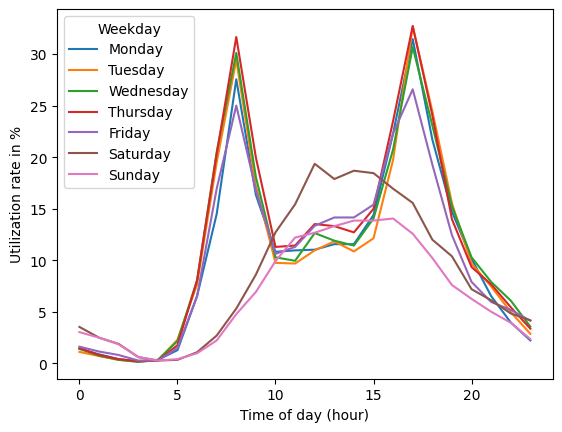

In [6]:
df_utilization_rate_median_per_hour = df_utilization_rate_per_hour.groupby(['Weekday','Time of day (hour)'])['Utilization rate in %'].median().reset_index()
df_utilization_rate_median_per_hour['Weekday'] = pd.Categorical(df_utilization_rate_median_per_hour['Weekday'],categories=days)
df_utilization_rate_median_per_hour = df_utilization_rate_median_per_hour.sort_values('Weekday')
sns.lineplot(data=df_utilization_rate_median_per_hour, x='Time of day (hour)', y='Utilization rate in %', hue='Weekday')

Findings:
- On work days, the utilization rate is highest at 8 am and 5 pm. This is probably due to the trips to and from work.
- On Saturday and Sunday, the usage rate is highest approximately between 12 pm and 3 pm. Here the bicycles are probably used for free time activities.

### Median of utilization rate per day

The following plot represents the median of the utilization rate per day over the year.

<AxesSubplot: xlabel='Date', ylabel='Utilization Rate'>

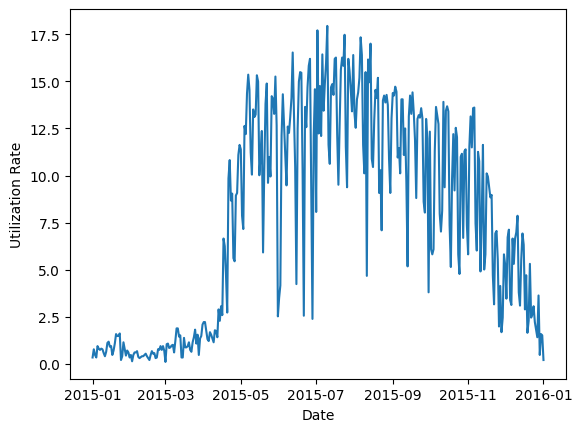

In [7]:
df_utilization_rate_per_day = df_splitted_trips.copy()
df_utilization_rate_per_day = df_utilization_rate_per_day.groupby(['Date', 'Time of day (hour)']).nunique()
df_utilization_rate_per_day['Utilization Rate'] = df_utilization_rate_per_day['bike_id']/amountOfBikes*100
df_utilization_rate_per_day = df_utilization_rate_per_day.groupby('Date')['Utilization Rate'].median().reset_index()
sns.lineplot(data=df_utilization_rate_per_day, x='Date', y='Utilization Rate')

### Median of utilization rate per week

The following plot represents the median of the utilization rate per week over the year.

<AxesSubplot: xlabel='Week', ylabel='Utilization Rate'>

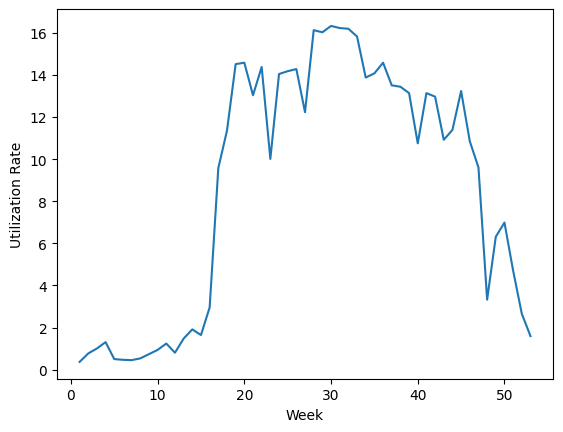

In [8]:
df_utilization_rate_per_week = df_splitted_trips.copy()
df_utilization_rate_per_week['Week'] = df_utilization_rate_per_week['start_time'].dt.isocalendar().week
df_utilization_rate_per_week = df_utilization_rate_per_week.groupby(['Date', 'Week', 'Time of day (hour)']).nunique()
df_utilization_rate_per_week['Utilization Rate'] = df_utilization_rate_per_week['bike_id']/amountOfBikes*100
df_utilization_rate_per_week = df_utilization_rate_per_week.groupby(['Week', 'Time of day (hour)'])['Utilization Rate'].median().reset_index()
df_utilization_rate_per_week = df_utilization_rate_per_week.groupby('Week')['Utilization Rate'].median().reset_index()
sns.lineplot(data=df_utilization_rate_per_week, x='Week', y='Utilization Rate')

# Bike utilization rate
With the Bike Utilization Rate, we calculate per bike how many minutes per hour the bike is used. 
$$ \text{Bike Utilization Rate} = {\text{Minutes bike is used}\over \text{hour}} $$

<AxesSubplot: xlabel='Time of day (hour)', ylabel='Average travel time with one bike (min/hour)'>

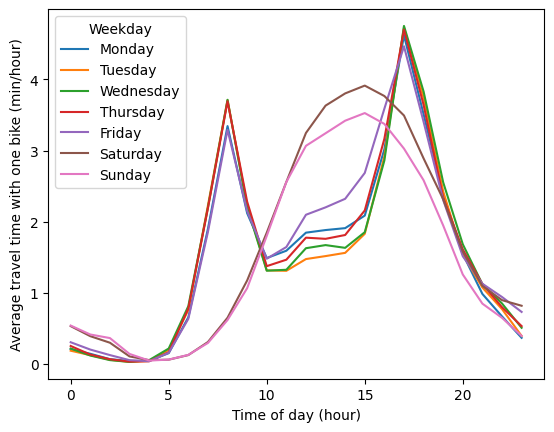

In [9]:
df_bike_utilization_rate = df_splitted_trips.copy()
df_bike_utilization_rate = df_splitted_trips.groupby(['bike_id', 'Date', 'Weekday', 'Time of day (hour)']).sum(['trip_length'])
df_bike_utilization_rate = df_bike_utilization_rate.reset_index()
# get sum of trip_length per day and hour in seconds
df_bike_utilization_rate = df_bike_utilization_rate.groupby(['Date', 'Weekday', 'Time of day (hour)']).sum(['trip_length'])
df_bike_utilization_rate['Average travel time with one bike (min/hour)'] = df_bike_utilization_rate['trip_length']/amountOfBikes/60
df_bike_utilization_rate = df_bike_utilization_rate.reset_index()
df_bike_utilization_rate_mean_per_hour = df_bike_utilization_rate.groupby(['Weekday','Time of day (hour)'])['Average travel time with one bike (min/hour)'].mean().reset_index()
df_bike_utilization_rate_mean_per_hour['Weekday'] = pd.Categorical(df_bike_utilization_rate_mean_per_hour['Weekday'],categories=days)
df_bike_utilization_rate_mean_per_hour = df_bike_utilization_rate_mean_per_hour.sort_values('Weekday')
sns.lineplot(data=df_bike_utilization_rate_mean_per_hour, x='Time of day (hour)', y='Average travel time with one bike (min/hour)', hue='Weekday')

Findings:
- The curves show how many minutes each bicycle was used on average per hour
- The Y-axis shows the length of use per bike in minutes per hour
- The X-axis shows the time of day from 0 am to 23 pm.
- The longest travel time per hour is on Saturdays. On average, it is higher than on other days of the week at all times
- Saturdays at 2 pm is the highest travel time, averaging 18 minutes per hour per bike
- In comparison to the curve of the fleet utilization rate, we see that the trips on the weekend are quite relatively longer than the trips on working days
- Additionally you can see, that bikes are used for a longer time in the afternoon (around 5 min./hour) than in the morning (around 4 min./hour) on working days, whereas the fleet utilization rate seems to be nearly equal in the morning and afternoon

### Revenue

![caption](data/thehubway_revenue_modell_2015.png)

The revenue modell above was exported from the Blue-Bikes Page in 2015 and access through the wayback machine. According to the modell, the revenue generated split in two parts: The fixed income through either subscription or 24/72-Hour passes and the variable income generated through overtime. 

Because we don't have any data to clearly identify the subscriber-id or unique temporary pass-id for each trip, it is impossible to account the direct contribution of the fixed income part to each trip. Because we can't clearly account the fixed income part of each trip, we can't interpolate the subscriber/temporary pass users for the smaller dataset. This means that, theoretically speaking, all the trips undertaken by subscribers in the smaller dataset could have be completed from the same subscriber. While this is highly unlikely, we can't fully rule out the possiblity - because we can't make any statements about the fixed part of the income generated by each trip. 

For this reason, we decided to remove the fixed income part from the entire revenue analysis and only focus on the revenue generated through overtime. In the following analysis, we will first calculate the overtime generated for each trip and afterwords look into different findings for the overtime revenue.   

#### Load Processed Dataframe

In [10]:
df_boston = pd.read_csv('./data/prepared/rides_data_prepared.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')
# Using end_time instead of start_time because revenue is only generated AFTER the trip as during the trip it is not clear how much revenue we get from the ride
df_boston['date'] = df_splitted_trips['end_time'].dt.date
df_boston['time_of_day_hour'] = df_splitted_trips['end_time'].dt.hour
df_boston['weekday'] = df_boston['end_time'].dt.day_name()
df_boston['month'] = df_boston['end_time'].dt.month_name()

def calculateOvertimeRevenue(tripLengthInSec, userType):
    revenue = 0.0
    # 31 min 
    if(tripLengthInSec >= 1860):
        revenue += 2
    # 61 Min 
    if(tripLengthInSec >= 3660):
        revenue += 4
    
    if(tripLengthInSec > 5400):
        tripLenghtLonger90MinInSec = tripLengthInSec - 5400
        revenue += np.ceil(tripLenghtLonger90MinInSec / 1800) * 8 

    if(userType == 'Subscriber'):
        # Apply 25% discount for subs
        revenue = revenue*0.75
    
    return revenue

df_boston['revenue_through_overtime'] = df_boston.apply(lambda row: calculateOvertimeRevenue(row.trip_length, row.user_type), axis=1)

df_boston_only_overtime_rides = df_boston[df_boston['revenue_through_overtime'] > 0]

df_boston_only_overtime_rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55474 entries, 59 to 1106090
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   start_time                  55474 non-null  datetime64[ns]
 1   end_time                    55474 non-null  datetime64[ns]
 2   start_station_id            55474 non-null  int64         
 3   end_station_id              55474 non-null  string        
 4   start_station_name          55474 non-null  string        
 5   end_station_name            55474 non-null  string        
 6   bike_id                     55474 non-null  int64         
 7   user_type                   55474 non-null  string        
 8   trip_length                 55474 non-null  float64       
 9   start_station_latitude      55474 non-null  float64       
 10  start_station_longitude     55474 non-null  float64       
 11  end_station_latitude        55474 non-null  float64

percent of userbase subscriber: 0.6660196474453439
percent of userbase Customer: 0.3339803525546561
total number of OT-Rides: 55474
total number of subscriber rides: 49998
total number of customer rides: 5476
percent of OT-rides from subscriber: 0.9012870894473086
percent of OT-rides from customer: 0.09871291055269135
sum of subscriber OT revenue: 88017.0
sum of customer OT revenue: 11972.0
percent of Subscriber OT revenue: 0.8802668293512287
percent of customer OT revenue: 0.11973317064877137


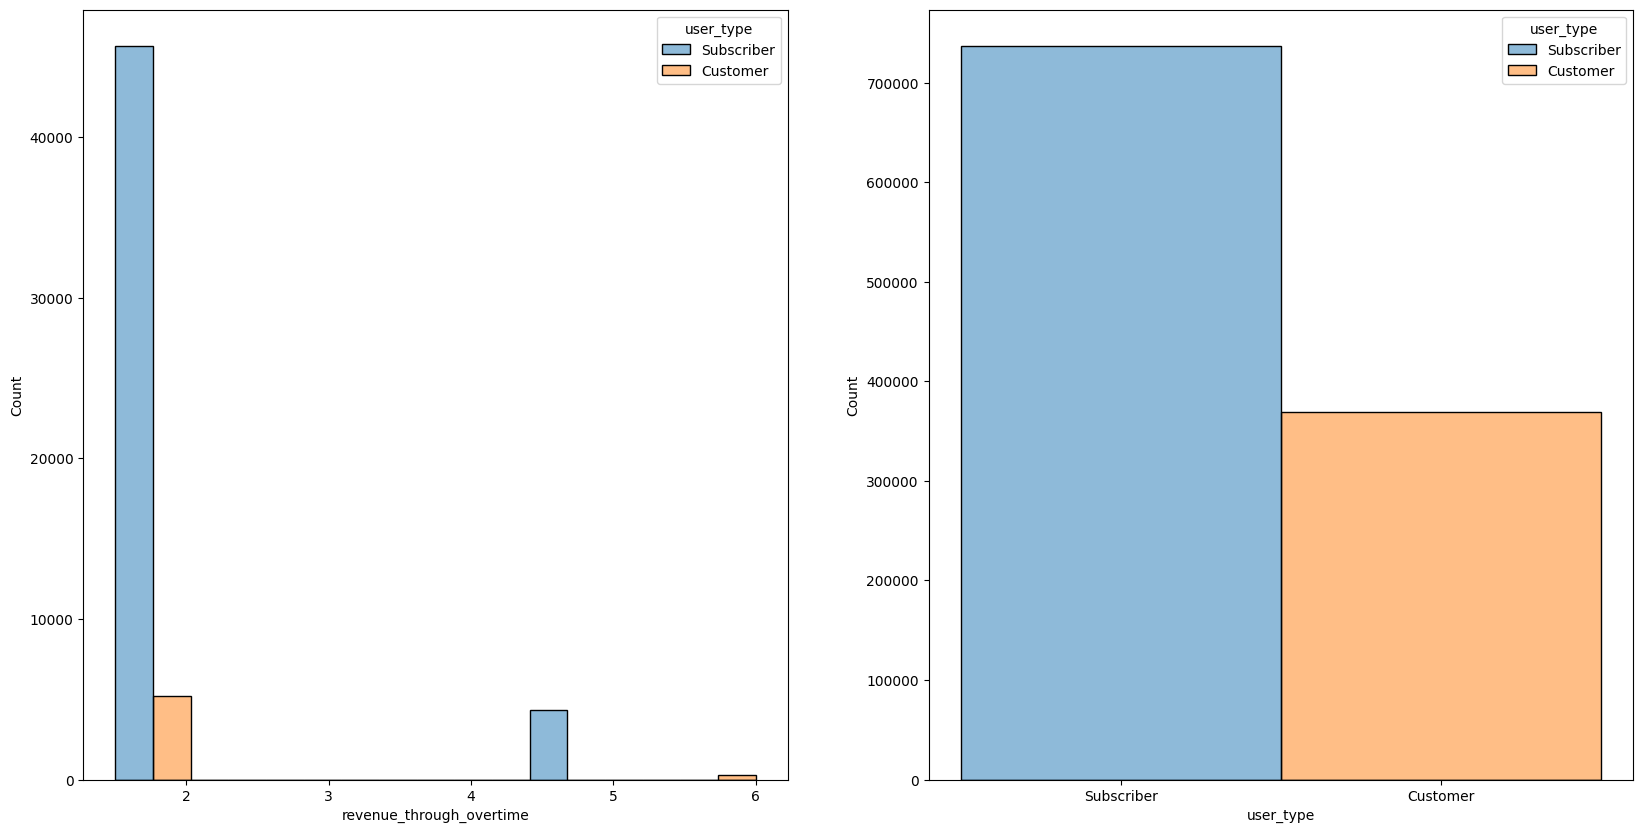

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(20,10))
sns.histplot(df_boston_only_overtime_rides, x='revenue_through_overtime', hue='user_type', ax=ax[0])
sns.histplot(df_boston, x='user_type', hue='user_type', ax=ax[1])

print(f'percent of userbase subscriber: {len(df_boston[df_boston["user_type"] == "Subscriber"])/len(df_boston)}')
print(f'percent of userbase Customer: {len(df_boston[df_boston["user_type"] == "Customer"])/len(df_boston)}')


print(f'total number of OT-Rides: {len(df_boston_only_overtime_rides)}')
print(f'total number of subscriber rides: {len(df_boston_only_overtime_rides[df_boston_only_overtime_rides["user_type"] == "Subscriber"])}')
print(f'total number of customer rides: {len(df_boston_only_overtime_rides[df_boston_only_overtime_rides["user_type"] == "Customer"])}')

print(f'percent of OT-rides from subscriber: {len(df_boston_only_overtime_rides[df_boston_only_overtime_rides["user_type"] == "Subscriber"])/len(df_boston_only_overtime_rides)}')
print(f'percent of OT-rides from customer: {len(df_boston_only_overtime_rides[df_boston_only_overtime_rides["user_type"] == "Customer"])/len(df_boston_only_overtime_rides)}')


print(f'sum of subscriber OT revenue: {df_boston_only_overtime_rides[df_boston_only_overtime_rides["user_type"] == "Subscriber"]["revenue_through_overtime"].sum()}')
print(f'sum of customer OT revenue: {df_boston_only_overtime_rides[df_boston_only_overtime_rides["user_type"] == "Customer"]["revenue_through_overtime"].sum()}')

print(f'percent of Subscriber OT revenue: {df_boston_only_overtime_rides[df_boston_only_overtime_rides["user_type"] == "Subscriber"]["revenue_through_overtime"].sum()/df_boston_only_overtime_rides["revenue_through_overtime"].sum()}')
print(f'percent of customer OT revenue: {df_boston_only_overtime_rides[df_boston_only_overtime_rides["user_type"] == "Customer"]["revenue_through_overtime"].sum()/df_boston_only_overtime_rides["revenue_through_overtime"].sum()}')



As we can see in the histogramms, a disporportionally high percantage of overtime revenue generated stems from subscribers. While they make up roughly 66% of the overall userbase, they account for around 90% of the overtime rides. This ration is also reflected in the percent of total revenue generated by the subscribers (88.02%) which is sligthly lower than the the percent of total rides (90%) because of the 25% reduction in overtime fees for the subscribers.

Looking at the distribution of overtimes revenue throughout an average day, we don't get any specifically interesting insights. Most of the hours hover slightly below the average of 1.802 Dollars per Ride, with the only exception of the nighttime between 1 am and 6 am showing divergence from this trend. 

<AxesSubplot: xlabel='week_num', ylabel='revenue_through_overtime'>

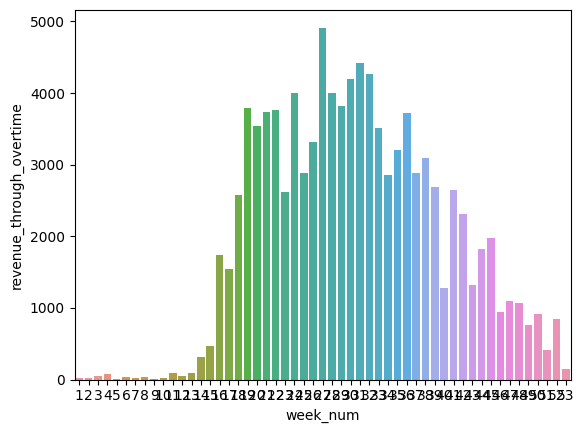

In [27]:
# Revenue per Week
df_boston_only_overtime_rides_week = df_boston_only_overtime_rides.copy()
df_boston_only_overtime_rides_week['week_num'] = df_boston_only_overtime_rides_week['end_time'].dt.isocalendar().week
df_boston_only_overtime_rides_week = df_boston_only_overtime_rides_week.groupby(by='week_num')['revenue_through_overtime'].sum().reset_index(name='revenue_through_overtime')
df_boston_only_overtime_rides_week.head()

sns.barplot(data=df_boston_only_overtime_rides_week, x='week_num', y='revenue_through_overtime')

<AxesSubplot: xlabel='weekday', ylabel='revenue_through_overtime'>

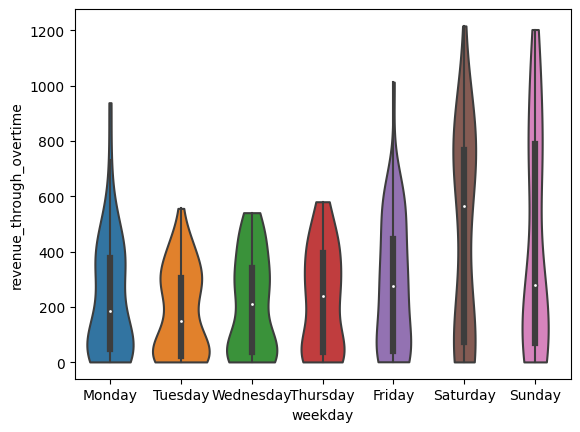

In [55]:
# Revenue per Weekday
df_boston_only_overtime_rides_weekday = df_boston_only_overtime_rides.copy()
df_boston_only_overtime_rides_weekday['day_of_year'] = df_boston_only_overtime_rides_weekday['end_time'].dt.day_of_year
df_boston_only_overtime_rides_weekday_doy = df_boston_only_overtime_rides_weekday.groupby(by='day_of_year')['revenue_through_overtime'].sum().reset_index(name='revenue_through_overtime')


df_merge_weekday = df_boston_only_overtime_rides_weekday[['day_of_year', 'weekday']]
df_merge_weekday = df_merge_weekday.drop_duplicates(subset='day_of_year')

df_boston_only_overtime_rides_weekday_doy = df_boston_only_overtime_rides_weekday_doy.merge(df_merge_weekday, on='day_of_year')
#df_boston_only_overtime_rides_weekday['day_of_year'] = df_boston_only_overtime_rides_weekday['end_time'].dt.day_of_year

df_boston_only_overtime_rides_weekday_doy['weekday'] = pd.Categorical(df_boston_only_overtime_rides_weekday_doy['weekday'], categories=['Monday', 'Tuesday', 'Wednesday' , 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df_boston_only_overtime_rides_weekday_doy = df_boston_only_overtime_rides_weekday_doy.sort_values('weekday', ascending=False)

sns.violinplot(data=df_boston_only_overtime_rides_weekday_doy, x='weekday', y='revenue_through_overtime', cut=0)

As we can see from the plots, the highest overtime 

C:\Users\Adrian\AppData\Local\Temp\ipykernel_12276\184307681.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ot_rides_month_percentage = df_ot_rides_count_month.append(df_rentals_total_month)


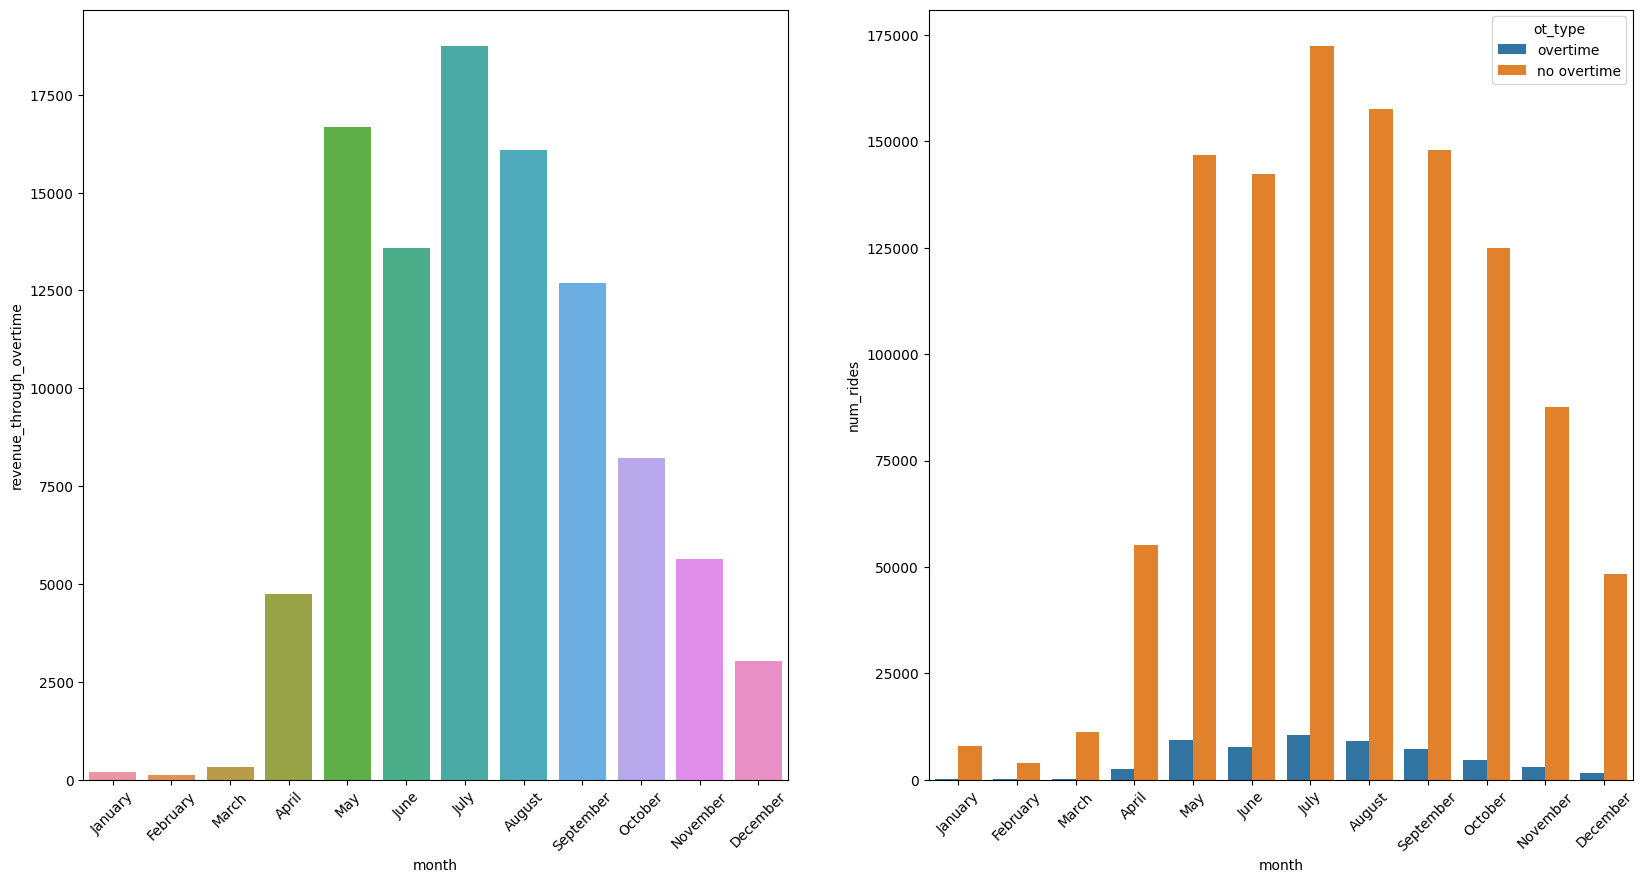

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(20,10))

# Count of rides per month
df_ot_rides_count_month = df_boston_only_overtime_rides.groupby(by='month').size().reset_index(name='num_rides')
df_ot_rides_count_month['month'] = pd.Categorical(df_ot_rides_count_month['month'], categories=['January', 'February', 'March' , 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
df_ot_rides_count_month['ot_type'] ='overtime'

# Second df to get total rides
df_rentals_total = df_boston.copy()
df_rentals_total['month'] = df_rentals_total['end_time'].dt.month_name()
df_rentals_total_month = df_rentals_total.groupby(['month']).size().reset_index(name='num_rides')
df_rentals_total_month['month'] = pd.Categorical(df_rentals_total_month['month'], categories=['January', 'February', 'March' , 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
df_rentals_total_month['ot_type'] ='no overtime'

# merge total df and cumsum df to get percentages per month
df_ot_rides_month_percentage = df_ot_rides_count_month.append(df_rentals_total_month)

# Sum of overtime revenue 
df_ot_rides_sum_month = df_boston_only_overtime_rides.groupby(by='month')['revenue_through_overtime'].sum().reset_index()
df_ot_rides_sum_month['month'] = pd.Categorical(df_ot_rides_count_month['month'], categories=['January', 'February', 'March' , 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
df_ot_rides_sum_month.sort_values('month')

sns.barplot(data=df_ot_rides_sum_month, x='month', y='revenue_through_overtime', ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(data=df_ot_rides_month_percentage, x='month', y='num_rides', hue='ot_type', ax=ax[1])
ax[1].tick_params(axis='x', rotation=45)

From the revenue generated (left Plot), we can see that during the winter month there is a lot less activity. Most of the revenue is generated in the summer months, with the highest revenue in August with around 18.000 Dollar. 



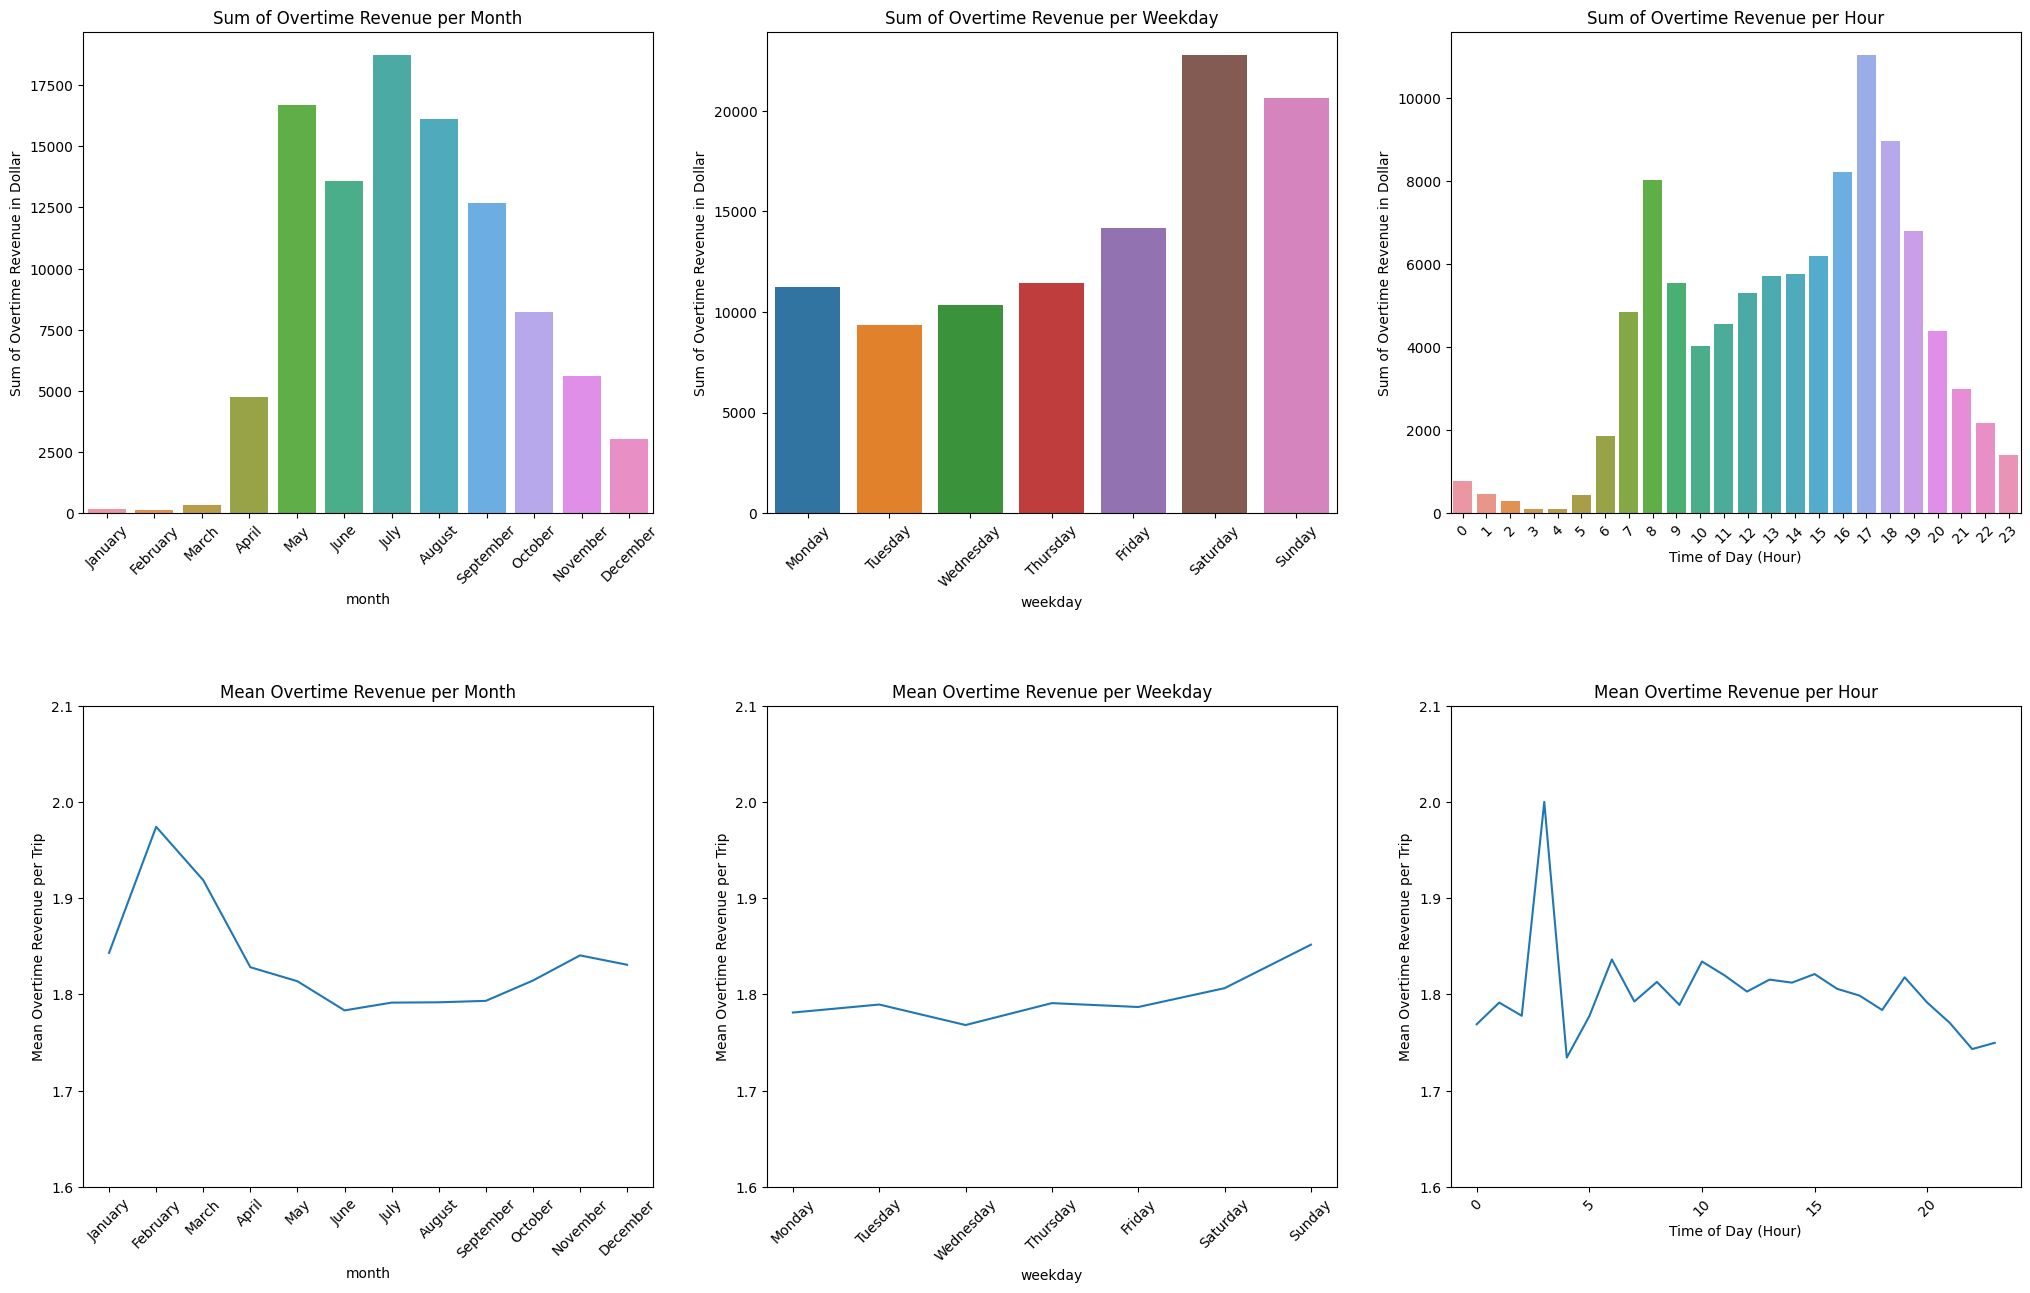

In [99]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,3,figsize=(25,15))
# absolut/mean rev per month
df_ot_rides_month = df_boston_only_overtime_rides.copy()

df_ot_rides_month['month'] = pd.Categorical(df_ot_rides_month['month'], categories=['January', 'February', 'March' , 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)

df_ot_rides_sum_month = df_ot_rides_month.groupby(by='month')['revenue_through_overtime'].sum().reset_index()
df_ot_rides_sum_month.sort_values('month', inplace=True)

df_ot_rides_mean_month = df_ot_rides_month.groupby(by='month')['revenue_through_overtime'].mean().reset_index()
df_ot_rides_mean_month.sort_values('month', inplace=True)

sns.barplot(data=df_ot_rides_sum_month, x='month', y='revenue_through_overtime', ax=ax[0][0])
ax[0][0].tick_params(axis='x', rotation=45)
ax[0][0].set_title('Sum of Overtime Revenue per Month')
ax[0][0].set(ylabel='Sum of Overtime Revenue in Dollar')


sns.lineplot(data=df_ot_rides_mean_month, x='month', y='revenue_through_overtime', ax=ax[1][0])
ax[1][0].tick_params(axis='x', rotation=45)
ax[1][0].set_title('Mean Overtime Revenue per Month')
ax[1][0].set(ylim=(1.6, 2.1))
ax[1][0].set(ylabel='Mean Overtime Revenue per Trip')


# absolut/mean rev per Weekday
df_ot_rides_weekday = df_boston_only_overtime_rides.copy()
df_ot_rides_weekday['weekday'] = pd.Categorical(df_ot_rides_weekday['weekday'], categories=['Monday', 'Tuesday', 'Wednesday' , 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

df_ot_rides_sum_weekday = df_ot_rides_weekday.groupby(by='weekday')['revenue_through_overtime'].sum().reset_index()
df_ot_rides_sum_weekday.sort_values('weekday')

df_ot_rides_mean_weekday = df_ot_rides_weekday.groupby(by='weekday')['revenue_through_overtime'].mean().reset_index()
df_ot_rides_mean_weekday.sort_values('weekday')

sns.barplot(data=df_ot_rides_sum_weekday, x='weekday', y='revenue_through_overtime', ax=ax[0][1])
ax[0][1].tick_params(axis='x', rotation=45)
ax[0][1].set_title('Sum of Overtime Revenue per Weekday')
ax[0][1].set(ylabel='Sum of Overtime Revenue in Dollar')


sns.lineplot(data=df_ot_rides_mean_weekday, x='weekday', y='revenue_through_overtime', ax=ax[1][1])
ax[1][1].tick_params(axis='x', rotation=45)
ax[1][1].set_title('Mean Overtime Revenue per Weekday')
ax[1][1].set(ylim=(1.6, 2.1))
ax[1][1].set(ylabel='Mean Overtime Revenue per Trip')


# absolut/mean rev per Hour of the day
df_ot_rides_hour = df_boston_only_overtime_rides.copy()

df_ot_rides_hour_sum = df_ot_rides_hour.groupby(by='time_of_day_hour')['revenue_through_overtime'].sum().reset_index()
df_ot_rides_hour_sum.sort_values('time_of_day_hour')

df_ot_rides_hour_mean = df_ot_rides_hour.groupby(by='time_of_day_hour')['revenue_through_overtime'].mean().reset_index()
df_ot_rides_hour_mean.sort_values('time_of_day_hour')

sns.barplot(data=df_ot_rides_hour_sum, x='time_of_day_hour', y='revenue_through_overtime', ax=ax[0][2])
ax[0][2].tick_params(axis='x', rotation=45)
ax[0][2].set_title('Sum of Overtime Revenue per Hour')
ax[0][2].set(ylabel='Sum of Overtime Revenue in Dollar')
ax[0][2].set(xlabel='Time of Day (Hour)')


sns.lineplot(data=df_ot_rides_hour_mean, x='time_of_day_hour', y='revenue_through_overtime', ax=ax[1][2])
ax[1][2].tick_params(axis='x', rotation=45)
ax[1][2].set_title('Mean Overtime Revenue per Hour')
ax[1][2].set(ylim=(1.6, 2.1))
ax[1][2].set(ylabel='Mean Overtime Revenue per Trip')
ax[1][2].set(xlabel='Time of Day (Hour)')



plt.subplots_adjust(hspace = 0.4)
plt.show()


### Clustering

### Correlation analysis between participatation and demand

In [16]:
import pandas as pd
import numpy as np
import math
# Import Data Set

df_boston = pd.read_csv('./data/prepared/rides_data_prepared.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
 
df_boston.head()
# Setup Demand as no of bikes rented in the current hour
df_demand = df_boston.resample(rule='H', on='start_time').size().reset_index(name='demand')
df_demand.columns = ['date_time', 'demand']
df_demand.head()

# Include Weather Data
df_weather = pd.read_csv('./data/weather_hourly_boston.csv')

df_weather.head()
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'], format='%Y-%m-%d %X')
df_demand = df_demand.merge(df_weather, how = 'inner', on = 'date_time')
df_demand.head()

# Calculate Demand Change
df_demand['demand_h-1'] = df_demand['demand'].shift(periods=1)
df_demand['demand_h-2'] = df_demand['demand'].shift(periods=2)

df_demand['demand_change_h-1'] = df_demand['demand'] / df_demand['demand_h-1']
df_demand['demand_change_h-2'] = df_demand['demand'] / df_demand['demand_h-2']

# Remove first two lines because no trailing
df_demand = df_demand[2::] 
# Remove all lines with infinity to not break further plotting
df_demand = df_demand[np.logical_and(df_demand['demand_change_h-1'] != math.inf, df_demand['demand_change_h-2'] != math.inf)]

df_demand.head()



,date_time,demand,max_temp,min_temp,precip,demand_h-1,demand_h-2,demand_change_h-1,demand_change_h-2
4,2015-01-01 10:00:00,8,-5.6,-5.6,0.0,2.0,4.0,4.000000,2.000000
5,2015-01-01 11:00:00,6,-5.0,-5.0,0.0,8.0,2.0,0.750000,3.000000
6,2015-01-01 12:00:00,11,-5.0,-5.0,0.0,6.0,8.0,1.833333,1.375000
7,2015-01-01 13:00:00,10,-5.6,-5.6,0.0,11.0,6.0,0.909091,1.666667
8,2015-01-01 14:00:00,21,-3.9,-3.9,0.0,10.0,11.0,2.100000,1.909091


C:\Users\Adrian\AppData\Local\Temp\ipykernel_12276\3263145801.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_demand.corr()


<AxesSubplot: >

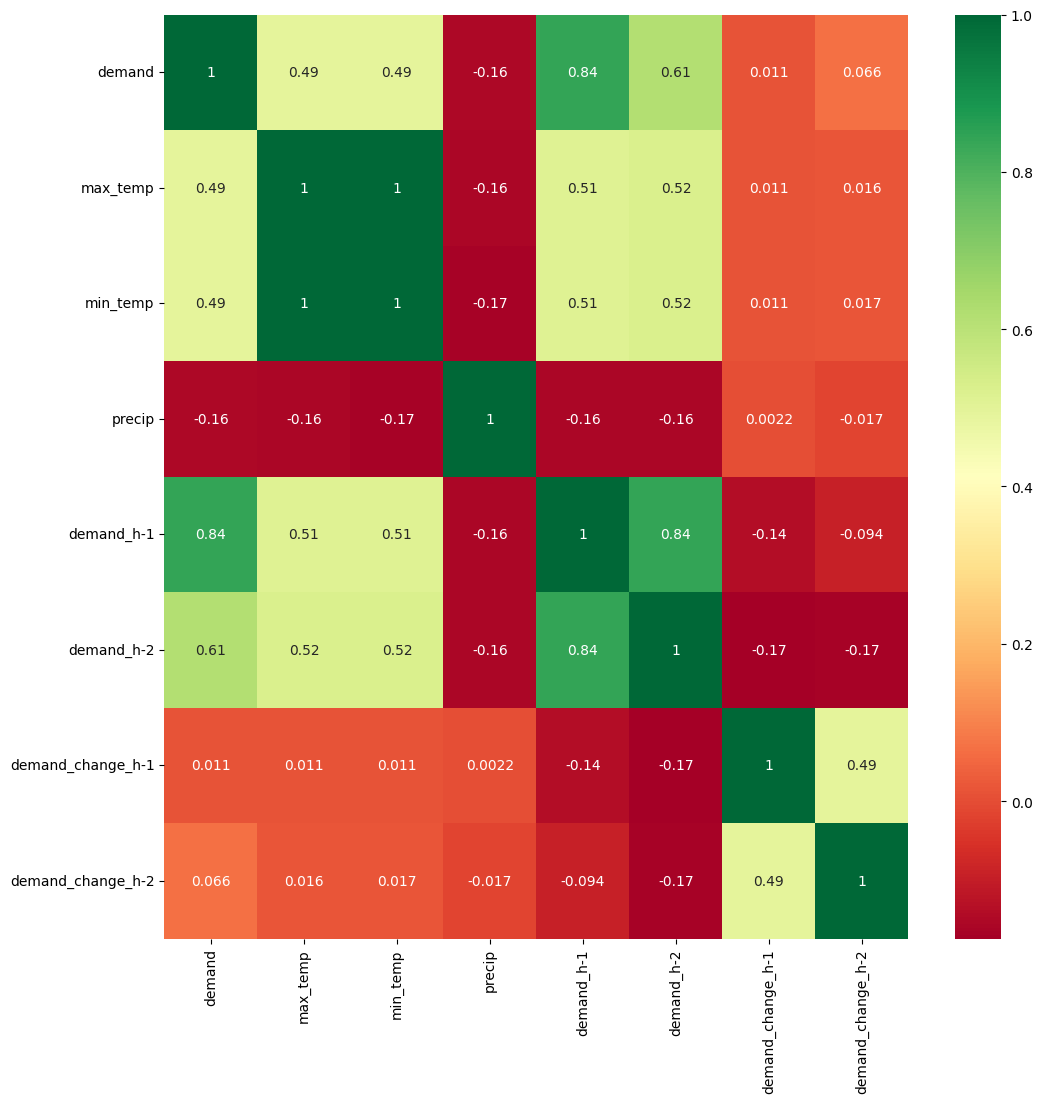

In [17]:
# Get correlation for percip and h-1 and h-2 demands
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df_demand.corr()
top_corr_features = corr_matrix.index
plt.figure(figsize=(12,12))

sns.heatmap(df_demand[top_corr_features].corr(),annot=True,cmap="RdYlGn")


#### KPI - Reduced GHG Emissions

The impact of bike sharing on the environment has been the topic of many studies. While bike sharing has a positive impact on greenhouse gas emissions, calculating the exact extend of this effect is rather difficult. The primary reason for this, aside from calculating the exact GHG lifecylce costs of the bike shaaring system itself, is the estimation of the transport modes substitued by the bike sharing systems. 

The assumption that a Bike sharing system (BSS) would purely replace traffic from cars is not correct, as in most cities, a BSS also competes with the public transport system for passengers and walking. The Transport mode substituted also heavily depends on the time of the day, location and itended usage (eg. leisure vs. commuting) and is therefore hard to estimate. 

Most studies on this topic choose an aproach that estimates the kilometers traveled through GPS or Geospatical Data (eg. calculate the distance between Start and End Dock) and apply a rule based system to classify the type of trip (eg. leisure or comute) to estimate the modal change rage. From this, the co2e-savings of each trip is calulated as the distance * co2e saved/km. 

For this analysis, we will only look at specific emissions from the trips itself and not the lifecylce system costs. To reduce the complexitiy, we will work with an average number of grams per km saved from the paper: "Quantifying greenhouse gas emissions reduction from bike share systems: a model considering real-world trips and transportation mode choice patterns". The paper looks at the BSS of eight different cities, one of them being the 2016 Boston data set. 

In [18]:
import seaborn as sns
import pandas as pd
import numpy as np
import locale
locale.setlocale(locale.LC_ALL, 'de_DE.utf-8')

# Average City bike speed: 12km/h source: https://sustainabilityinfo.com/transportation/what-is-the-average-speed-for-urban-cycling/, assumtion: little bit below because we also need to take into account locking/unlocking of bikes and other stops
df_boston = pd.read_csv('./data/prepared/rides_data_prepared.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')

meters_per_hour = 12000
seconds_per_hour = 3600

average_co2_reduced_per_mile_in_g = 345.02
average_co2_reduced_per_km_in_g = 345.02/1.60934
average_co2_reduced_per_km_in_kg = average_co2_reduced_per_km_in_g/1000

df_boston['distance_traveled_in_m'] = df_boston['trip_length'] * (meters_per_hour/seconds_per_hour)

# kg = m/1000 * kg/km * 
df_boston['co2_saved_comp_to_car_in_kg'] = df_boston['distance_traveled_in_m']/1000 * average_co2_reduced_per_km_in_kg

df_boston['month'] = df_boston['start_time'].dt.month_name()
df_boston['month'] = pd.Categorical(df_boston['month'], categories=['January', 'February', 'March' , 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)

print(f'total co2 saved in 2015 in kg: {locale.format_string("%d", round(df_boston["co2_saved_comp_to_car_in_kg"].sum(), 2), 1)}')


total co2 saved in 2015 in kg: 638.673


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')])

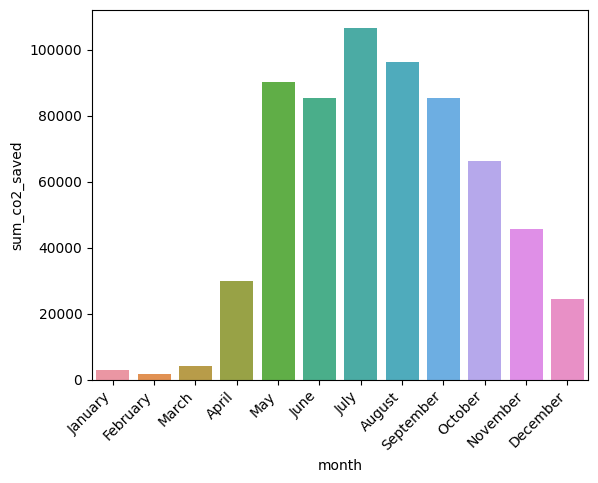

In [19]:
import matplotlib.pyplot as plt

df_boston_co2_month_sum = df_boston.groupby(['month'])['co2_saved_comp_to_car_in_kg'].sum().reset_index(name='sum_co2_saved')

sns.barplot(data=df_boston_co2_month_sum, x='month', y='sum_co2_saved')
plt.xticks(rotation=45, ha='right')


As we are using a distance based co2-savings estimation, we can see a strong similaritiy between this plot and the total distance traveled (see time demand patterns). In January, February and March there is a strong dip in the co2 saved because most of the stations are not open during the winter.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')])

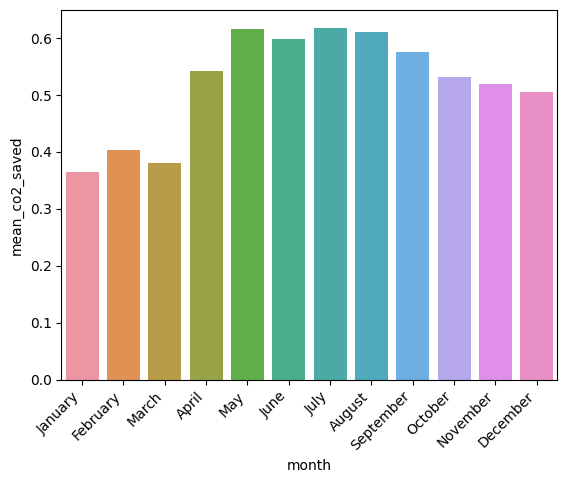

In [20]:
import matplotlib.pyplot as plt

df_boston_co2_month_avg = df_boston.groupby(['month'])['co2_saved_comp_to_car_in_kg'].mean().reset_index(name='mean_co2_saved')

sns.barplot(data=df_boston_co2_month_avg, x='month', y='mean_co2_saved')
plt.xticks(rotation=45, ha='right')

Aside from the drop number of trips we we can also see a reduction in length of the trips leading to fewer co2 savings per trip in the winter months.

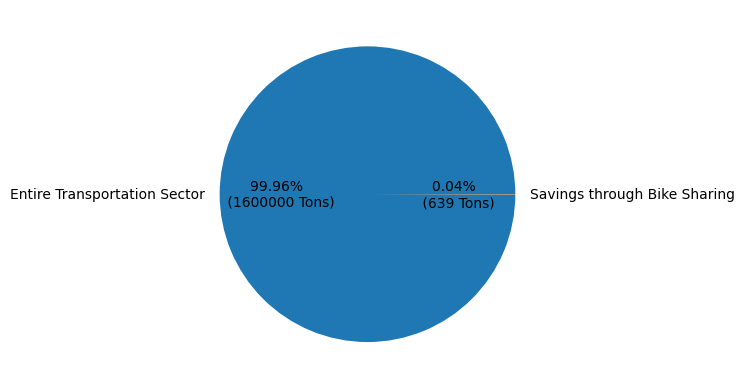

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
# Pie chart total + pie chart tansportation 
# Source of total data: https://www.boston.gov/sites/default/files/embed/b/boston_ghg_inventory_2005-2015.pdf

co2_emission_boston_transportation_sector_2015_tons=1.6*1000000
co2_emissions_saved_through_bss_tons = df_boston_co2_month_sum['sum_co2_saved'].sum()/1000

df_total_emissions_pie = pd.DataFrame({'labels' : ['Entire Transportation Sector', 'Savings through Bike Sharing'], 'co2_in_tons':[co2_emission_boston_transportation_sector_2015_tons, co2_emissions_saved_through_bss_tons]})

# Seaborn color palette 
colors = sns.color_palette('pastel')[0:5]


def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% \n ({v:d} Tons)'.format(p=pct,v=val)
    return my_autopct

plt.pie(df_total_emissions_pie['co2_in_tons'], labels=df_total_emissions_pie['labels'], autopct=make_autopct(df_total_emissions_pie['co2_in_tons']))
plt.show()


While saving 639 Tons of CO2 might initially sound impressive, set in relation with the emissions of the entire transportation sector in boston, we can see the contribution is actually quite small. However, co2 emissions are not the only thing that could be reduced through a bike sharing system: Other noteable mentions are fine particles, noise pollution and use of inner city areas for parking spaces.